# TP OMA 2: Stochastic first order methods

## 1 - Linear regression

In this pratical exercise, we will train again a linear regression model as in TP1 but using stochastic first order methods as seen in the lectures.

Recall the following:

In general, linear regression model do not require to solve an optimization model as the solution can be derived by inverting the normal equations (if the problem has the right properties). However, in the large scale setting, the inversion of the system required in the normal equation is not possible and approximate solutions are computeed using first order methods.

Given a matrix $A\in\mathbb{R}^{n\times d}$ and $b\in\mathbb{R}^n$, we want to minimize the following objective function

$$f(x)=\frac{1}{2n}\|Ax-b\|^2=\frac{1}{2n}\displaystyle\sum_{i=1}^n(a_i^\top x -b_i)^2$$

One can see the function $f$ is $\mu$ strongly convex with $\mu=\lambda_{min}(\nabla^2 f(x))=\frac{1}{n}\lambda_{min}(A^T A)$ and $L$ smooth with $L=\lambda_{max}(\nabla^2 f(x))=\frac{1}{n}\lambda_{max}(A^T A)$, since here the Hessian matrix is constant, independent of $x$.

When $A^{T} A$ is invertible, which is the case here, then we have a simple closed form solution for (the unique) $x^* = \text{argmin}_{x \in \mathbb{R}^d} f(x)$. Indeed, solving $\nabla f(x^*) = 0$ leads to $x^* = (A^T A)^{-1} A^T b$. However when $n$ and $d$ are large (which is the case in modern "big data" problems), using this formula is prohibitively expensive from a computational viewpoint, hence the necessity of using first order optimization algorithms.

In the examples used in the following, whenever possible, in order to exhibit the convergence rates, we will also compute $f(x^*)$ using the normal equations ($x^*=(A^T A)^{-1} A^T b$). 

Additionally, we will also consider regularized version of the least square problem in order to enforce some structure in the solution as seen in the lecture as well (ex: L1 regulatrisation for sparsity, L2 for robustness to data perturbation,...).

We will first load some useful packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import sklearn as sk
from sklearn.datasets import make_regression

### Generating data

In order to generate regression datasets, we will use a dataset generation function from the wellknown \texttt{scikit-learn} machine learning python environment. The function documentation is available at  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html.

Create (by filling in the code below) a python function that will apply this function in order generate a datasets of $n$ samples of dimension $d$ (number of features).


In [2]:
def generate_dataset(n,d):
    X,Y = make_regression(n, d, n_informative=100, bias=2, coef=False, noise=10.0)
    return X,Y

In [3]:
n=10000
d=10

X,Y=generate_dataset(n,d)
print("X=",X)
print("Y=",Y)

A = np.c_[np.ones(n), X]


X= [[ 0.08900655 -0.19626234 -0.91880576 ... -0.59110977  0.07114183
   0.66498634]
 [-0.94333253 -0.33699886 -1.02877932 ...  0.21680973  0.13791757
   1.66108943]
 [-1.47113511 -0.59770334  0.57095956 ... -0.00785631 -0.8451483
   0.8548504 ]
 ...
 [-0.3438095  -0.48001272 -2.07891601 ... -0.40442762 -1.83807017
   1.25685421]
 [ 0.2288198   0.65292653 -0.04165665 ...  0.41857832  0.54471982
  -0.14352278]
 [-1.58340004  0.18722329 -1.6738506  ...  0.55300346 -2.57594142
   0.37256899]]
Y= [-175.28946498 -107.7186987  -153.88173566 ... -275.36530248  138.52208089
 -179.08402729]


### Computing $f(x^*)$

In [4]:
def full_objective(Y, A, x):
    # Compute the least squares objective over the whole dataset
    n = A.shape[0]
    return 1/(2*n)*np.linalg.norm(np.dot(A, x)-Y)**2

In [5]:
x_star = np.linalg.solve(A.T@A, A.T@Y)
best_objective = full_objective(Y, A, x_star)
print("f(x*) = ", best_objective)
print(x_star)


f(x*) =  49.76345371884294
[ 1.85264689 26.46046185 44.03005846 56.2721435   5.52229453 71.00696284
 51.06350489 85.5822578  20.89456599 16.29298021  2.50121379]


### Benchmark: gradient descent

In [7]:
def gradient_regression(Y, A, x):
    """
    Compute the gradient of the regression function for the entire dataset.
    
    :param Y: a numpy array of shape (n)
    :param A: a numpy array of shape (n, d)
    :param x: compute the gradient at these parameters, numpy array of shape (d)
    
    :return: gradient: numpy array of shape (d)
    """
    
    n = A.shape[0]
    
    grad = 1/n*(A.T@(A@x - Y))
    return grad

def gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        # update x through the gradient update
        x = x - lr*grad
    
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

import datetime

# Define the parameters of the algorithm.
nmax = 100
lr=0.1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
gd_objectives, gd_iterates = gradient_descent(
    Y, A, x_initial, nmax, lr)
end_time = datetime.datetime.now()

# Print result
execution_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=execution_time))


GD(0000/0000/9999): objective =    8790.96
GD(0001/0001/9999): objective =    7123.09
GD(0002/0002/9999): objective =    5773.67
GD(0003/0003/9999): objective =    4681.87
GD(0004/0004/9999): objective =    3798.48
GD(0005/0005/9999): objective =    3083.67
GD(0006/0006/9999): objective =    2505.26
GD(0007/0007/9999): objective =    2037.20
GD(0008/0008/9999): objective =    1658.43
GD(0009/0009/9999): objective =    1351.89
GD(0010/0010/9999): objective =    1103.81
GD(0011/0011/9999): objective =     903.02
GD(0012/0012/9999): objective =     740.51
GD(0013/0013/9999): objective =     608.98
GD(0014/0014/9999): objective =     502.51
GD(0015/0015/9999): objective =     416.32
GD(0016/0016/9999): objective =     346.56
GD(0017/0017/9999): objective =     290.08
GD(0018/0018/9999): objective =     244.35
GD(0019/0019/9999): objective =     207.34
GD(0020/0020/9999): objective =     177.37
GD(0021/0021/9999): objective =     153.10
GD(0022/0022/9999): objective =     133.45
GD(0023/002

### Stochastic gradient descent

Let us first define the gradient function that will be used next in the descent algorithm.

In [8]:
def minibatch_gradient(Y_batch, A_batch, x):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param Y_batch: a numpy array of shape (batch_size)
    :param A_batch: a numpy array of shape (batch_size, d)
    :param x: compute the mini-batch gradient at these parameters, numpy array of shape (d)
    
    :return: stoc_grad: numpy array of shape (d)
    """
    
    
    n = A_batch.shape[0]
    
    stoc_grad = 1/n*(A_batch.T@(A_batch@x - Y_batch))
    return stoc_grad


In [9]:
choice = np.random.choice(3, 5)
print(choice)
A_batch = A[choice]
A_batch

[2 2 0 0 0]


array([[ 1.        , -1.47113511, -0.59770334,  0.57095956, -0.5937785 ,
        -0.23941609, -2.29235523,  0.2870917 , -0.00785631, -0.8451483 ,
         0.8548504 ],
       [ 1.        , -1.47113511, -0.59770334,  0.57095956, -0.5937785 ,
        -0.23941609, -2.29235523,  0.2870917 , -0.00785631, -0.8451483 ,
         0.8548504 ],
       [ 1.        ,  0.08900655, -0.19626234, -0.91880576, -0.14398928,
        -1.17701651, -0.92121604,  0.40598266, -0.59110977,  0.07114183,
         0.66498634],
       [ 1.        ,  0.08900655, -0.19626234, -0.91880576, -0.14398928,
        -1.17701651, -0.92121604,  0.40598266, -0.59110977,  0.07114183,
         0.66498634],
       [ 1.        ,  0.08900655, -0.19626234, -0.91880576, -0.14398928,
        -1.17701651, -0.92121604,  0.40598266, -0.59110977,  0.07114183,
         0.66498634]])

Using your gradient function, propose an implementation of the gradient descent to solve the linear regression problem.

In [10]:
def stoc_gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr, batch_size):
    """
    Stochastic gradient descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    :param batch_size: number of samples used for calculating the stochastic gradient 
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        n=len(Y)
        choice = np.random.choice(n, batch_size)
        A_batch = A[choice]
        Y_batch = Y[choice]
        
        stocgrad= minibatch_gradient(Y_batch, A_batch, x)
        
        # update x through the gradient update
        x = x - lr*stocgrad
    
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        print("SGD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

Test now your SGD on the regression problem you have generated earlier. You may try several values for the step size and various type of step sizes (constant, diminishing).

In [29]:
import datetime

# Define the parameters of the algorithm.
nmax = 500
lr=0.05
lr = np.linspace(0.01, 0.2, 5)
batch_size=100
tabObjectivesSto = []
tabTimesSto = []


for lrVal in lr:
    # Initialization
    x_initial = np.zeros(A.shape[1])
    # Start GD
    start_time = datetime.datetime.now()
    stocgd_objectives, stocgd_iterates = stoc_gradient_descent(
        Y, A, x_initial, nmax, lrVal,batch_size)
    end_time = datetime.datetime.now()
    tabObjectivesSto.append(stocgd_objectives)
    tabTimesSto.append((end_time - start_time).total_seconds())

# Print result
# execution_time = (end_time - start_time).total_seconds()
# print("SGD: execution time={t:.3f} seconds".format(t=execution_time))

SGD(0000/0000/9999): objective =   10620.63
SGD(0001/0001/9999): objective =   10410.52
SGD(0002/0002/9999): objective =   10230.75
SGD(0003/0003/9999): objective =    9936.59
SGD(0004/0004/9999): objective =    9713.84
SGD(0005/0005/9999): objective =    9485.27
SGD(0006/0006/9999): objective =    9306.83
SGD(0007/0007/9999): objective =    9088.92
SGD(0008/0008/9999): objective =    8890.88
SGD(0009/0009/9999): objective =    8720.40
SGD(0010/0010/9999): objective =    8559.13
SGD(0011/0011/9999): objective =    8397.74
SGD(0012/0012/9999): objective =    8245.69
SGD(0013/0013/9999): objective =    8099.52
SGD(0014/0014/9999): objective =    7921.31
SGD(0015/0015/9999): objective =    7765.86
SGD(0016/0016/9999): objective =    7545.44
SGD(0017/0017/9999): objective =    7388.81
SGD(0018/0018/9999): objective =    7265.77
SGD(0019/0019/9999): objective =    7101.41
SGD(0020/0020/9999): objective =    6971.64
SGD(0021/0021/9999): objective =    6842.40
SGD(0022/0022/9999): objective =

Let us now plot the convergence profile, i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$:


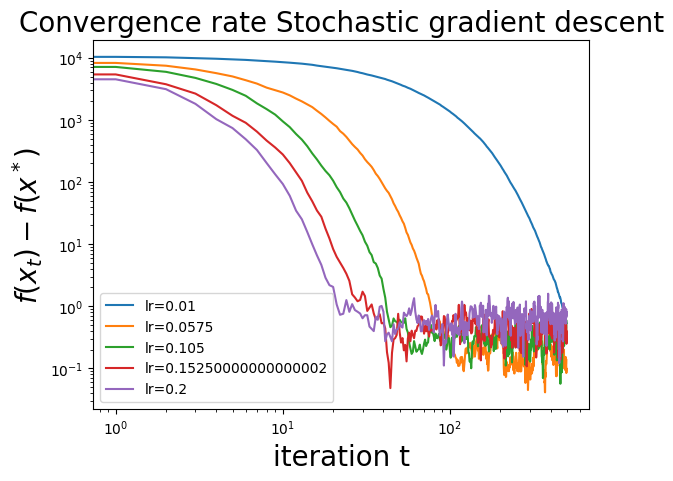

In [30]:
plt.title('Convergence rate Stochastic gradient descent', fontsize = 20)
for index, stocgd_objectives in enumerate(tabObjectivesSto):
    lrVal = str(lr[index])
    plt.loglog(stocgd_objectives - best_objective,  label=f"lr={lrVal}")
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend()
plt.show()

Compare your results with the classic (full batch) gradient method.

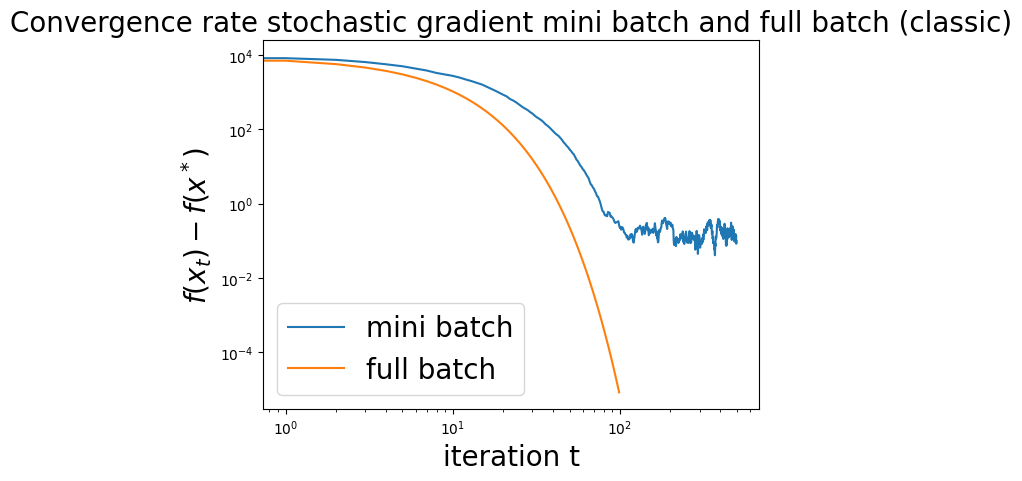

In [31]:
plt.figure(4)
plt.title('Convergence rate stochastic gradient mini batch and full batch (classic)', fontsize = 20)
plt.loglog(tabObjectivesSto[1] - best_objective, label = r'mini batch')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)

plt.loglog(gd_objectives - best_objective, label = r'full batch')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

## 2 - Support Vector Machine

In this section, we will implement a stochastic (sub)-gradient algorithm in order to solve the soft primal margin SVM training problem. Recall the problem:
$$
\displaystyle \min_{w,b} \frac{1}{2}\|w\|^2 + C\sum_{i=1}^{n} \max\{0,1-y_i(w^Tx_i+b)\} 
$$
where $C$ is a parameter. In the following, we will write $\theta=(w,b)$ where $w=(\theta_1,\ldots,\theta_d)$ and $b=\theta_{d+1}$.

Let us first import libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.utils import shuffle

Then define a function to generate two clusters of 2D data point that we will try to separate using the SVM. The number of points generated is a parameter of the function.

In [13]:
def generatedata2(n):
    # n must be an even integer
    np.random.seed(0)
    mean1, cov1, n1 = [1, 5], [[1,1],[1,2]], int(n/2)  # n/2 samples of class 1
    x1 = np.random.multivariate_normal(mean1, cov1, n1)
    y1 = np.ones(n1, dtype=np.int_)
    mean2, cov2, n2 = [2.5, 2.5], [[1,0],[0,1]], int(n/2) # n/2 samples of class -1
    x2 = np.random.multivariate_normal(mean2, cov2, n2)
    y2 = -np.ones(n2, dtype=np.int_)
    x = np.concatenate((x1, x2), axis=0) # concatenate the samples
    y = np.concatenate((y1, y2))
    x,y = shuffle(x,y)
    
    return [x,y]

Let us now define a function that will plot the data and a function to plot the hyperplane (and the supporting hyperplanes) generated by the SVM and represented in the form of $\theta=(w,b)$ (meaning $w^Tx+b=0$).

In [27]:
def plotdata(x,y):
    for i in range(x.shape[0]):
        if y[i]==-1:
            cl='bo';
        else:
                cl='r+';
        plt.plot(x[i,0],x[i,1],cl);
    return

def plothyperplane(w,b,x):
    xx=np.linspace(x[:,0].min(),x[:,0].max(),100);
    #print(xx)
    yy=(-b-w[0]*xx)/w[1];
    yy1=yy+1/np.linalg.norm(w);
    yy2=yy-1/np.linalg.norm(w);
    #print(yy)
    print(xx)
    print(yy)
    print(yy1)
    print(yy2)
    plt.plot(xx,yy,'k-')
    plt.plot(xx,yy1,'g-')
    plt.plot(xx,yy2,'g-')
    return

Define first the function that computes the value of the SVM problem objective function at $\theta$.

In [21]:
def SVMobjective(x,y,d,C,theta):
    part1 = 1/2 * np.linalg.norm(theta[:d])**2
    #print(x.shape)
    #print(1 - y@(theta[:d]@x.T + theta[d]))
    part2 = np.maximum(np.zeros(y.shape[0]), 1 - y@(theta[:d]@x.T + theta[d]))*C
    return np.min(part1 + part2)

Define now a new function that will take as parameters a batch of samples $(x_i,y_i)_{i=1,\ldots,batch_size}$ and return a stochastic subgradient of the objective function at $\theta$ by considering only the terms of the batch. 

In [29]:
def minibatch_subgrad_svm(x_batch,y_batch,d,C,theta):
    temp1 = - y_batch@(x_batch)
    temp2 = -C*y_batch
    condition = 1 - y_batch@(theta[:d]@x_batch.T + theta[d])
    mask = condition > 0

    derivee1 = temp1*mask
    part1 = derivee1*C + theta[:d]
    derivee2 = temp2*mask
    part2 = np.sum(derivee2)
    return np.concatenate([part1, [part2]])

Use the above function to implement the following svm_SGD algorithm:

In [22]:
def svm_SGD(x,y,d,C,theta,batch_size,lr,nmax):
    
    thetas = [theta]
    objectives = []
    for epoch in range(nmax):
        for iter in range(int(len(y)/batch_size)):
            indices = np.random.choice(n, batch_size, replace=True)
            SVMgrad=minibatch_subgrad_svm(x[indices], y[indices], d, C, theta)
            print(SVMgrad)
            # update x through the gradient update
            theta -= lr*SVMgrad
                
            # store x and objective
            thetas.append(theta.copy())
            objective=SVMobjective(x,y,d,C,theta)
            objectives.append(objective)
            print("SGD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                          bi=epoch, ti=len(y) - 1, l=objective))
    return objectives, thetas


[  522.66950119 -1360.79516594     0.        ]
SGD(0000/0000/0999): objective =     106.25
[-5.22669501 13.60795166  0.        ]
SGD(0000/0000/0999): objective =     104.13
[-5.17442806 13.47187214  0.        ]
SGD(0000/0000/0999): objective =     102.06
[-5.12268378 13.33715342  0.        ]
SGD(0000/0000/0999): objective =     100.03
[-5.07145694 13.20378189  0.        ]
SGD(0000/0000/0999): objective =      98.04
[-5.02074237 13.07174407  0.        ]
SGD(0000/0000/0999): objective =      96.09
[-4.97053495 12.94102663  0.        ]
SGD(0000/0000/0999): objective =      94.18
[-4.9208296  12.81161636  0.        ]
SGD(0000/0000/0999): objective =      92.30
[-4.8716213 12.6835002  0.       ]
SGD(0000/0000/0999): objective =      90.47
[-4.82290509 12.5566652   0.        ]
SGD(0000/0000/0999): objective =      88.66
[-4.77467604 12.43109854  0.        ]
SGD(0001/0001/0999): objective =      86.90
[-4.72692928 12.30678756  0.        ]
SGD(0001/0001/0999): objective =      85.17
[-4.679659

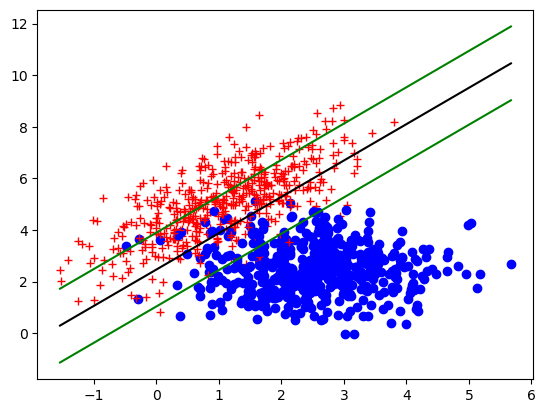

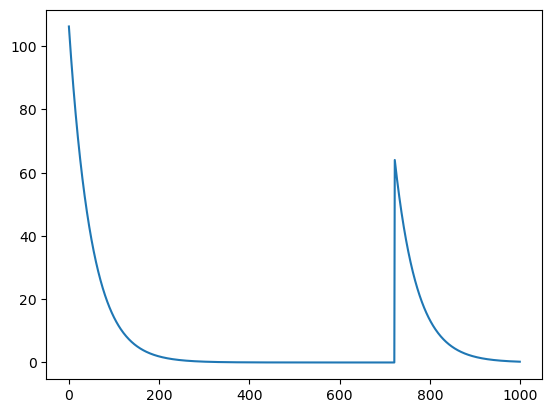

In [30]:
plt.close("all");

d=2
n=1000
C=10
nmax=100
lr=0.01
batch_size=100

[x,y]=generatedata2(n);

plt.figure(0);
plotdata(x,y);

theta_initial=np.empty([d+1])
theta_initial[:d]=np.zeros([2]);
theta_initial[d]=0

obj=np.empty(nmax);
objectives, thetas = svm_SGD(x,y,d,C,theta_initial,batch_size,lr,nmax)
predict=np.empty(n);
w=thetas[-1][:d]
b=thetas[-1][d]

print(w)
print(b)

error=0;
for j in range(n):
    predict[j]=np.sign(np.dot(x[j,:],w)+b);
    if y[j]!=predict[j]:
        error+=1;
plothyperplane(w,b,x);

#error
training_error=error*100/n
print('Training error=',training_error)

plt.figure(1);
plt.plot(range(len(objectives)),objectives)